## Load Dataset from Kaggle

In [0]:
# Install kaggel API and create directory kaggle
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
# import API key into colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"evgeniimunin","key":"4e69131d861b5cbcbbe8bc6c58f1329f"}'}

In [0]:
# copy the API key to the kaggle dir
!cp kaggle.json ~/.kaggle/""

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# list the datasets
!kaggle datasets list

ref                                                       title                                              size  lastUpdated          downloadCount  
--------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
dgomonov/new-york-city-airbnb-open-data                   New York City Airbnb Open Data                      2MB  2019-08-12 16:24:45           9443  
lakshyaag/india-trade-data                                India - Trade Data                                  1MB  2019-08-16 16:13:58           5622  
therohk/ireland-historical-news                           The Irish Times - Waxy-Wany News                   47MB  2019-08-24 15:36:54            811  
bradklassen/pga-tour-20102018-data                        PGA Tour Golf Data                                 94MB  2019-08-30 00:09:59           5094  
r3w0p4/bournemouth-venues                                 Venues in Bournemouth         

In [6]:
# download dataset files 
!kaggle competitions download -c recursion-cellular-image-classification

 28% 5.00M/17.6M [00:00<00:00, 20.1MB/s]
100% 17.6M/17.6M [00:00<00:00, 50.7MB/s]
  0% 0.00/358k [00:00<?, ?B/s]
100% 358k/358k [00:00<00:00, 114MB/s]
  0% 0.00/561k [00:00<?, ?B/s]
100% 561k/561k [00:00<00:00, 144MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 110MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 78.1MB/s]
  0% 0.00/204k [00:00<?, ?B/s]
100% 204k/204k [00:00<00:00, 67.3MB/s]
  0% 0.00/34.8k [00:00<?, ?B/s]
100% 34.8k/34.8k [00:00<00:00, 36.0MB/s]
100% 15.7G/15.7G [03:30<00:00, 72.8MB/s]
100% 15.7G/15.7G [03:31<00:00, 80.0MB/s]
100% 29.9G/29.9G [05:32<00:00, 125MB/s]
100% 29.9G/29.9G [05:32<00:00, 96.5MB/s]


In [0]:
# unzip and replace option -o
!unzip -q -o /content/train.zip -d train

In [0]:
!unzip -q /content/test.zip -d test

In [0]:
!unzip -q /content/train.csv.zip -d train_csv

## Install and import EfficientNet PyTorch

In [0]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

## Install and import Albumentations

In [0]:
from albumentations import (
  HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, ElasticTransform, RandomBrightness, RandomContrast
)
import cv2
import numpy as np
from urllib.request import urlopen
from matplotlib import pyplot as plt

## Load packeges

In [0]:
import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import math

In [0]:
path_data = '/content/'
device = 'cuda'
num_classes = 1108
batch_size = 16
num_epochs = 3

## Dataset / Batch Loader

In [0]:
class ImageDS(D.Dataset):
    """
    Images have 6 channels
    """
    def __init__(self, df, img_dir, mode='train', site=1, 
                 channels=[1,2,3,4,5,6],
                 transform=None):
        self.records = df.to_records(index=False) # convert DF to NP record array
        self.channels = channels
        self.site = site # get path to image
        self.mode = mode
        self.img_dir = img_dir
        self.len = df.shape[0]
        self.transform = transform
        
    def _load_img_as_tensor(self, file_name):
        """
        convert PIL image into torch tensor
        """ 
        with Image.open(file_name) as img:
            return torchvision.transforms.ToTensor()(img)
        
    def _get_img_path(self, index, channel):
        """
        from NP record records get path details of image: epxeriemnt. well, plate for the given channel 
        path example ../input/train/HUVEC-08/Plate1/I11_s1_w6.png
        """
        experiment = self.records[index].experiment 
        well = self.records[index].well 
        plate = self.records[index].plate
        # retirn path
        return '/'.join([self.img_dir, self.mode, experiment, 
                         f'Plate{plate}', f'{well}_s{self.site}_w{channel}.png'])
    
    def _augment(self, img):
        """
        Apply transforms from albu package 
        """
        #return img
        aug = Compose([
                RandomRotate90(p=0.5),
                OneOf([
                    HorizontalFlip(p=0.5),
                    VerticalFlip(p=0.5)
                ]),
                GridDistortion(p=0.3),
                OneOf([
                    RandomBrightness(p=0.5),
                    RandomContrast(p=0.5)
                ])
              ])

        img = img.numpy() # convert to numpy
        img = aug(image=img)['image']
        img = torch.tensor(img).float() # return back to torch tensor
        if img.shape[0] != len(self.channels):
          img = torch.transpose(img, 0, 1)
        return img

    
    def __getitem__(self, index):
        # get image path for the given channel
        paths = [self._get_img_path(index, ch) for ch in self.channels]
        
        # convert img into tensor and stack tensors  in the given dimension
        img = torch.cat([self._load_img_as_tensor(img_path) for img_path in paths])
        
        # Apply transforms using Albu
        if self.transform is not None:
          img = self._augment(img)
        
        #print('final', img.shape)
        if self.mode == 'train':
            return img, self.records[index].sirna, self.records[index].experiment# return img tensor/ label/ experiment
        else:
            return img, self.records[index].id_code, self.records[index].experiment # ???
        
        
    def __len__(self):
        """
        total number of samples in the dataset
        """
        return self.len
    

In [0]:
#%% Generate dataframes
df = pd.read_csv(path_data+'/train_csv/train.csv')
df_train, df_val = train_test_split(df, test_size=0.15, random_state=42, shuffle=True)
df_test = pd.read_csv(path_data+'/test.csv')
print(df.shape, df_train.shape, df_val.shape, df_test.shape)
# ok

# split df's into experiments
df_train_exp_dict = {}
df_val_exp_dict = {}
df_test_exp_dict = {}
df_train['exp'] = df_train['experiment'].str[:-3]
df_val['exp'] = df_val['experiment'].str[:-3]
df_test['exp'] = df_test['experiment'].str[:-3]
unique_train_exp = df_train['exp'].unique()
unique_val_exp = df_val['exp'].unique()
unique_test_exp = df_test['exp'].unique()

for exp in unique_train_exp:
    df_train_exp_dict[exp] = df_train[df_train['exp'] == exp]
for exp in unique_val_exp:
    df_val_exp_dict[exp] = df_val[df_val['exp'] == exp]
for exp in unique_test_exp:
    df_test_exp_dict[exp] = df_test[df_test['exp'] == exp]

(36515, 5) (31037, 5) (5478, 5) (19897, 4)


In [0]:
# train
ds_dict = {}
for exp in df_train_exp_dict:
    ds_dict[exp] = ImageDS(df_train_exp_dict[exp], path_data, transform=True)
    for i in range(3):
        #Create transformed datasets
        ds_temp = ImageDS(df_train_exp_dict[exp], path_data, transform=True)
        ds_dict[exp] = torch.utils.data.ConcatDataset([ds_dict[exp], ds_temp])

#val
ds_val_dict = {}
for exp in df_val_exp_dict:
    ds_val_dict[exp] = ImageDS(df_val_exp_dict[exp], path_data, transform=None)

# test
ds_test_dict = {}
for exp in df_test_exp_dict:
    ds_test_dict[exp] = ImageDS(df_test_exp_dict[exp], path_data, mode='test', transform=None)


print(len(ds_dict['RPE']), len(ds_temp), len(ds_val_dict['RPE']), len(ds_test_dict['RPE']))
print(ds_dict['RPE'])
print(ds_dict['RPE'][0][0].shape, ds_dict['RPE'][0][0].mean(), ds_dict['RPE'][0][0].std())
# 0 - image, 1 - label, 2 - experiment
# ok


26428 2819 1146 4417
torch.Size([6, 512, 512]) tensor(0.0320) tensor(0.0199)


In [0]:
# Batch loader
loader_dict = {}
for exp in df_train_exp_dict:
    loader_dict[exp] = D.DataLoader(ds_dict[exp], batch_size, shuffle=True, num_workers=2)

val_loader_dict = {}
for exp in df_val_exp_dict:
    val_loader_dict[exp] = D.DataLoader(ds_val_dict[exp], batch_size, shuffle=False, num_workers=2)

tloader_dict = {}
for exp in df_test_exp_dict:
    tloader_dict[exp] = D.DataLoader(ds_test_dict[exp], batch_size, shuffle=False, num_workers=2)

3 torch.Size([16, 6, 512, 512]) torch.Size([6, 512, 512]) <class 'torch.Tensor'>
torch.Size([512, 512, 6])
torch.Size([512, 512, 6])


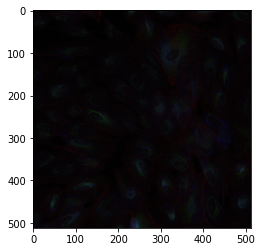

In [0]:
## Visualize example image
imgs = next(iter(loader_dict['RPE']))
index_vis = 0
print(len(imgs), imgs[0].shape, imgs[0][0].shape, type(imgs[0]))
# imgs[0] - batch of tensors
# imgs[1] - batch of labels
temp = torch.transpose(imgs[0][index_vis], 0, 2)
print(temp.shape)
temp = torch.transpose(temp, 0, 1)
print(temp.shape)

plt.imshow(temp[:,:,:3])
plt.show()

## Define Model

In [0]:
from collections import OrderedDict

class EffNetb0(nn.Module):
    def __init__(self, model_load_path=None):
        super(EffNetb0, self).__init__() # deriving from Module
        
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1108)
        for param in model.parameters():
              param.requires_grad = True
        
        # change count input channels of our model
        trained_kernel = model._conv_stem.weight
        new_conv = nn.Sequential(nn.Conv2d(6, 32, kernel_size=(3,3), stride=(2,2), bias=False),
                                 nn.ZeroPad2d(padding=(0,1,0,1))
                                )
        with torch.no_grad():
          new_conv[0].weight[:,:] = torch.stack([torch.mean(trained_kernel,1)]*6, dim=1)
        model._conv_stem = new_conv
        
        if model_load_path:
            # current model dict
            #model_dict = model.state_dict()
            
            # load pretrained state dict
            print('Load pretrained model')
            state_dict = torch.load(model_load_path)
            new_state_dict = OrderedDict([(k[6:], v) if k[:1] != '_' else (k, v) for k, v in state_dict.items()])
            model.load_state_dict(new_state_dict)
        
        model = model.to(device)
        self.model = model
        
    def forward(self, x):
        logits = self.model(x)
        return logits


In [0]:
#%% Define model / Load pretrained model
# define model paths
model_names = {'HEPG2': 'effnetb0_v11_010919_HEPG2.pth',
               'HUVEC': 'effnetb0_v11_010919_HUVEC.pth',
               'RPE': 'effnetb0_v11_010919_RPE.pth',
               'U2OS': 'effnetb0_v11_010919_U2OS.pth'}

models_dict = {}
for exp in unique_train_exp:
    models_dict[exp] = EffNetb0(model_names[exp])
    
# check the model is on device
print(device)
next(models_dict['RPE'].parameters()).is_cuda

Loaded pretrained weights for efficientnet-b0
Load pretrained model
Loaded pretrained weights for efficientnet-b0
Load pretrained model
Loaded pretrained weights for efficientnet-b0
Load pretrained model
Loaded pretrained weights for efficientnet-b0
Load pretrained model
cuda


True

## Train model

In [0]:
def evaluate_single_epoch(model, dataloader, criterion, 
                          batch_size, epoch, device=None, exp=None):
  model.eval()
  
  running_loss = 0
  running_corrects = 0
  
  with torch.no_grad():
    total_size = len(dataloader.dataset)
    total_step = math.ceil(total_size / batch_size)
    
    for i, data in enumerate(dataloader):
      try:
        if device:
          x, y = data[0].to(device), data[1].to(device)
        else:
          x, y = data[0], data[1]

        output = model(x)
        target = torch.zeros_like(output, device=device)
        target[np.arange(x.size(0)), y] = 1
        
        loss = criterion(output, y)
        running_loss += loss.item()
        # Calculate accuracy
        preds = torch.argmax(output, 1)
        running_corrects += torch.sum(preds == y).data.cpu().detach().numpy()
      
      except RuntimeError:
        print('validation batch_size error')

    # show val_loss, val_acc
    print('---------------------------------------------------------------')
    print('Exp: {} - Epoch: {} - Iter: {}/ {} - Val Loss: {:.5f}, Val Acc: {:.4f}%'.format(exp, epoch+1, i, total_step,
                                                                           running_loss/total_size,
                                                                           running_corrects/total_size))
    
    del loss, output, y, x, target
      
def train_single_epoch(model, dataloaders, criterion, 
                       optimizer, batch_size, epoch, 
                       scheduler, model_save_path, 
                       device=None, exp=None):
  scheduler.step()
  model.train()
  
  dataloader, val_dataloader = dataloaders[0], dataloaders[1]
  
  running_loss = 0
  running_corrects = 0
  total_size = len(dataloader.dataset)
  total_step = math.ceil(total_size / batch_size)

  for i, data in enumerate(dataloader):
    model.train()
    try:
      # train
      if device:
          x, y = data[0].to(device), data[1].to(device)
      else:
          x, y = data[0], data[1]
      optimizer.zero_grad()
      output = model(x)
      
      target = torch.zeros_like(output, device=device)
      target[np.arange(x.size(0)), y] = 1
      
      loss = criterion(output, y)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      # Calculate accuracy
      preds = torch.argmax(output, 1)
      running_corrects += torch.sum(preds == y).data.cpu().detach().numpy()    
 
      # show train_loss/ train_acc each 50 batches
      if i % 50 == 49:
        print('Exp: {} - Epoch: {} - Iter: {}/ {} - Train Loss: {:.5f}, Train Acc: {:.4f}'.format(exp, 
                                                                                                  epoch+1, i, 
                                                                                                  total_step,
                                                                                                  running_loss/50,
                                                                                                  running_corrects/batch_size/50))
        running_loss = 0
        running_corrects = 0
        
      if i % 400 == 399:
        # val phase
        evaluate_single_epoch(model, val_dataloader, criterion, 
                              batch_size, epoch, device, exp)
        # save the model
        torch.save(model.state_dict(),model_save_path)
        model.train()
        
      del loss, output, y, x, target
        
    except RuntimeError:
      print('train batch_size error')
  
def train_model(model, dataloaders, num_epochs, 
                criterion, optimizer, scheduler, 
                model_save_path, batch_size=1, device=None, exp=None):
  start_epoch = 0  
  for epoch in range(start_epoch, num_epochs):
    # train phase
    train_single_epoch(model, dataloaders, criterion, 
                       optimizer, batch_size, epoch, 
                       scheduler, model_save_path, 
                       device, exp)    
    # save the model
    torch.save(model.state_dict(),model_save_path)
        

In [0]:
import math
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
dataloaders_dict = {}
optimizers_dict = {}
expl_lr_scheduler_dict = {}
for exp in unique_train_exp:
    dataloaders_dict[exp] = [loader_dict[exp], val_loader_dict[exp]]
    optimizers_dict[exp] = torch.optim.Adam(models_dict[exp].parameters(), lr=0.00015)
    expl_lr_scheduler_dict[exp] = lr_scheduler.StepLR(optimizers_dict[exp], step_size=1, gamma=0.5)

model_save_path = {unique_train_exp[i]: 'effnetb0_v11_050919_{}.pth'.format(unique_train_exp[i]) 
                    for i in range(len(unique_train_exp))}

In [0]:
# train and validate model
exps_to_improve = ['U2OS', 'HEPG2', 'RPE']
for exp in exps_to_improve:
    train_model(models_dict[exp], 
                dataloaders_dict[exp], 
                num_epochs, 
                criterion, 
                optimizers_dict[exp], 
                expl_lr_scheduler_dict[exp], 
                model_save_path[exp],
                batch_size=batch_size,
                device=device,
                exp=exp)

Exp: U2OS - Epoch: 1 - Iter: 49/ 705 - Train Loss: 2.35436, Train Acc: 0.5175
Exp: U2OS - Epoch: 1 - Iter: 99/ 705 - Train Loss: 2.20497, Train Acc: 0.5125
Exp: U2OS - Epoch: 1 - Iter: 149/ 705 - Train Loss: 2.26131, Train Acc: 0.5062
Exp: U2OS - Epoch: 1 - Iter: 199/ 705 - Train Loss: 2.31094, Train Acc: 0.5212
Exp: U2OS - Epoch: 1 - Iter: 249/ 705 - Train Loss: 2.20329, Train Acc: 0.5425
Exp: U2OS - Epoch: 1 - Iter: 299/ 705 - Train Loss: 2.06157, Train Acc: 0.5613
Exp: U2OS - Epoch: 1 - Iter: 349/ 705 - Train Loss: 2.07322, Train Acc: 0.5613
Exp: U2OS - Epoch: 1 - Iter: 399/ 705 - Train Loss: 2.12601, Train Acc: 0.5675
---------------------------------------------------------------
Exp: U2OS - Epoch: 1 - Iter: 31/ 32 - Val Loss: 0.42664, Val Acc: 0.0416%
Exp: U2OS - Epoch: 1 - Iter: 449/ 705 - Train Loss: 2.03360, Train Acc: 0.5713
Exp: U2OS - Epoch: 1 - Iter: 499/ 705 - Train Loss: 1.95774, Train Acc: 0.5887
Exp: U2OS - Epoch: 1 - Iter: 549/ 705 - Train Loss: 1.92210, Train Acc: 0.

## Prediction/ Submit

### Define method + check experiments

In [0]:
# Prediction for test
def prediction(model, loader, batch_size, exp):
    preds = np.empty(0)
    total_size = len(loader.dataset)
    total_step = math.ceil(total_size / batch_size)
    for i, data in enumerate(loader):
      try:
          x = data[0].to(device)
          output = model(x)
          idx = output.max(dim=-1)[1].cpu().numpy()
          preds = np.append(preds, idx, axis=0)
          print('Exp: {} - Iter: {}/ {} - x.shape: {}'.format(exp, i, total_step, x.shape))
          
          del output, x
          
      except:
        print('test batch_szie error for shape: {}'.format(x.shape))
    return preds

In [0]:
val_preds_dict[exp] = prediction(model, val_loader, batch_size)

In [0]:
# Define vectors of exps/ sirnas for ds_val
exps = [x[2][:-3] for x in ds_val]
sirnas = [x[1] for x in ds_val]

In [0]:
exps = [x[2][:-3] for x in ds_val]

In [0]:
# Map val_preds with experiments from ds_val in DF
print(val_preds)
#exps1 = [x[:-3] for x in exps]
df_exp = pd.DataFrame({'experiment': exps, 'sirna': sirnas, 'sirna_pred': val_preds})
df_exp['equal'] = np.where(df_exp['sirna']==df_exp['sirna_pred'], 1, 0)
#df_exp['experiement'] = df_exp['experiment'].str[:-3]
print(df_exp.shape)
print(df_exp.head())

df_eq = df_exp.groupby('experiment').count()
df_eq['count'] = df_exp.groupby('experiment').sum()['equal']
#df_eq['equal_ratio'] = df_eq['equal'] / df['count']
#df_eq['equal_ratio'] = df_eq.apply(lambda row: int(row.count) / int(row.equal), axis=1)

print(df_eq)

[ 102.  549.  147. ... 1051.  294.  915.]
(5478, 4)
  experiment  sirna  sirna_pred  equal
0      HUVEC    255       102.0      0
1      HUVEC   1080       549.0      0
2       U2OS    469       147.0      0
3       U2OS    247       917.0      0
4      HUVEC    638       384.0      0
            sirna  sirna_pred  equal  count
experiment                                 
HEPG2        1175        1175   1175    120
HUVEC        2652        2652   2652    992
RPE          1146        1146   1146    186
U2OS          505         505    505     16


### Prediction/ Submit

In [0]:
#%% Define model / Load pretrained model
# define model paths
model_names = {'HEPG2': 'effnetb0_v11_050919_HEPG2.pth',
               'HUVEC': 'effnetb0_v11_050919_HUVEC.pth',
               'RPE': 'effnetb0_v11_050919_RPE.pth',
               'U2OS': 'effnetb0_v11_050919_U2OS.pth'}

models_dict = {}
for exp in unique_train_exp:
    models_dict[exp] = EffNetb0(model_names[exp])
    
# check the model is on device
print(device)
next(models_dict['RPE'].parameters()).is_cuda

Loaded pretrained weights for efficientnet-b0
Load pretrained model
Loaded pretrained weights for efficientnet-b0
Load pretrained model
Loaded pretrained weights for efficientnet-b0
Load pretrained model
Loaded pretrained weights for efficientnet-b0
Load pretrained model
cuda


True

In [0]:
preds_dict = {}
for exp in unique_train_exp:
  preds_dict[exp] = prediction(models_dict[exp], tloader_dict[exp], batch_size, exp)

Exp: HUVEC - Iter: 0/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 1/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 2/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 3/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 4/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 5/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 6/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 7/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 8/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 9/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 10/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 11/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 12/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 13/ 553 - x.shape: torch.Size([16, 6, 512, 512])
Exp: HUVEC - Iter: 14/ 553 - x.shape: torch.Size([16, 6, 5

In [0]:
# Concatenate all the experiments in preds array
count  = 0
preds_array = np.array([])
for exp in preds_dict:
  print(len(preds_dict[exp]), type(preds_dict[exp]))
  count += len(preds_dict[exp])
print(count)

exps = ['HEPG2', 'HUVEC', 'RPE', 'U2OS']
preds_array = np.concatenate((preds_dict[exps[0]], 
                              preds_dict[exps[1]],
                              preds_dict[exps[2]],
                              preds_dict[exps[3]]))
preds_array.shape

8846 <class 'numpy.ndarray'>
4429 <class 'numpy.ndarray'>
4417 <class 'numpy.ndarray'>
2205 <class 'numpy.ndarray'>
19897


(19897,)

In [0]:
submission = pd.read_csv(path_data + '/test.csv')
submission['sirna'] = preds_array.astype(int)
submission.to_csv('submission.csv', index=False, columns=['id_code','sirna'])